In [1]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

In [2]:
path = r"D:\KULIAH\KULIAH\SAINS DATA\SEMESTER 3\KECERDASAN BUATAN\PROJEK_AI\AI DATASET RAPI - GABUNGAN.csv"

df = pd.read_csv(path)
df.head()

,ID,TEMPAT,FAKULTAS,HARI,KUARTAL,Kebisingan (Db),Suhu (Celcius),Kelembaban (Persen),Kekuatan(dbm)
0,1,FATISDA - Dalam,FATISDA,SENIN,Pagi,48.3,27.8,75,-55
1,2,FATISDA - Luar,FATISDA,SENIN,Pagi,33.0,28.7,75,-53
2,3,FMIPA - Samping Lift Lantai Bawah,FMIPA,SENIN,Pagi,26.0,29.2,74,-61
3,4,FMIPA - Pojok Statistika,FMIPA,SENIN,Pagi,30.1,28.9,75,-65
4,5,FMIPA - Atas Tidak Ada Atap,FMIPA,SENIN,Pagi,27.1,30.8,68,-69


In [3]:
df.columns = df.columns.str.strip()

In [4]:
df = df.rename(columns={
    'Suhu (Celcius)': 'suhu',
    'Kekuatan(dbm)': 'wifi',
    'Kelembaban (Persen)': 'kelembapan',
    'Kebisingan (Db)': 'kebisingan'
})

In [5]:
#BUAT INPUT DAN OUTPUT

# -------- INPUT VARIABLE -------- #
suhu = ctrl.Antecedent(np.arange(14, 43, 1), 'suhu')
wifi = ctrl.Antecedent(np.arange(-90, 1, 1), 'wifi')
kelembapan = ctrl.Antecedent(np.arange(0, 91, 1), 'kelembapan')
kebisingan = ctrl.Antecedent(np.arange(0, 101, 1), 'kebisingan')
kenyamanan = ctrl.Consequent(np.arange(0, 10.1, 0.1), 'kenyamanan')


# SUHU °C (Adaptasi iklim + toleransi orang Indo)
suhu['dingin'] = fuzz.trapmf(suhu.universe, [14, 14, 20, 25])
suhu['sedang'] = fuzz.trimf(suhu.universe, [24, 28, 30])
suhu['panas']  = fuzz.trapmf(suhu.universe, [29, 32, 42, 42])

# KELEMBAPAN % (Karakter tropis lembab)
kelembapan['kering'] = fuzz.trapmf(kelembapan.universe, [0, 0, 35, 50])
kelembapan['sedang'] = fuzz.trimf(kelembapan.universe, [45, 55, 65])
kelembapan['lembab'] = fuzz.trapmf(kelembapan.universe, [60, 70, 90, 90])

# WIFI dBm (Versi jaringan real kampus/cafe Indo)
wifi['lemah']  = fuzz.trapmf(wifi.universe, [-90, -90, -75, -60])
wifi['sedang'] = fuzz.trimf(wifi.universe, [-65, -50, -35])
wifi['kuat']   = fuzz.trapmf(wifi.universe, [-40, -25, 0, 0])

# KEBISINGAN dB (Toleransi orang Indonesia terhadap bising)
kebisingan['rendah'] = fuzz.trapmf(kebisingan.universe, [0, 0, 40, 50])
kebisingan['sedang'] = fuzz.trimf(kebisingan.universe, [45, 60, 70])
kebisingan['tinggi'] = fuzz.trapmf(kebisingan.universe, [65, 75, 100, 100])

# =============================================
#   MEMBERSHIP FUNCTION (OUTPUT)
#   Skor Realistis (karena rata-rata rare >7)
# =============================================

kenyamanan['tidak_nyaman'] = fuzz.trapmf(kenyamanan.universe, [0, 0, 2.8, 4.2])
kenyamanan['cukup']        = fuzz.trimf(kenyamanan.universe, [3.8, 5.5, 7.1])
kenyamanan['nyaman']       = fuzz.trapmf(kenyamanan.universe, [6.8, 8.3, 10, 10])

RULE NYAMAN

In [6]:
# R1 – Suhu sedang + kebisingan rendah → Nyaman
rule1 = ctrl.Rule(suhu['sedang'] & kebisingan['rendah'], kenyamanan['nyaman'])

# R2 – Suhu dingin (adem) + kebisingan rendah → Nyaman
rule2 = ctrl.Rule(suhu['dingin'] & kebisingan['rendah'], kenyamanan['nyaman'])

# R3 – Kelembapan sedang + kebisingan rendah → Nyaman
rule3 = ctrl.Rule(kelembapan['sedang'] & kebisingan['rendah'], kenyamanan['nyaman'])

# R4 – WiFi kuat + suhu dingin/sedang → Nyaman
rule4 = ctrl.Rule(wifi['kuat'] & (suhu['dingin'] | suhu['sedang']), kenyamanan['nyaman'])

# R5 – WiFi sedang + suhu sedang + kebisingan rendah → Nyaman
rule5 = ctrl.Rule(wifi['sedang'] & suhu['sedang'] & kebisingan['rendah'], kenyamanan['nyaman'])

rule6 = ctrl.Rule(suhu['sedang'] & kebisingan['sedang'] & wifi['kuat'],
                   kenyamanan['nyaman'])

rule7 = ctrl.Rule(suhu['dingin'] & kebisingan['sedang'] & wifi['sedang'],
                   kenyamanan['nyaman'])

rule8 = ctrl.Rule(suhu['sedang'] & kelembapan['sedang'] & wifi['kuat'],
                   kenyamanan['nyaman'])

rule9 = ctrl.Rule(suhu['sedang'] & wifi['kuat'], kenyamanan['nyaman'])

RULE CUKUP

In [7]:
# R10 – Suhu panas tapi kebisingan rendah → Cukup
rule10 = ctrl.Rule(suhu['panas'] & kebisingan['rendah'], kenyamanan['cukup'])

# R11 – Suhu dingin + kebisingan sedang → Cukup
rule11 = ctrl.Rule(suhu['dingin'] & kebisingan['sedang'], kenyamanan['cukup'])

# R12 – Suhu sedang + kebisingan sedang → Cukup
rule12 = ctrl.Rule(suhu['sedang'] & kebisingan['sedang'], kenyamanan['cukup'])

# R13 – WiFi sedang + kebisingan sedang → Cukup
rule13 = ctrl.Rule(wifi['sedang'] & kebisingan['sedang'], kenyamanan['cukup'])

# R14 – Kelembapan lembab tapi suhu sedang → Cukup
rule14 = ctrl.Rule(kelembapan['lembab'] & suhu['sedang'], kenyamanan['cukup'])

# R15 – Kelembapan kering + suhu sedang → Cukup
rule15 = ctrl.Rule(kelembapan['kering'] & suhu['sedang'], kenyamanan['cukup'])


RULE TIDAK NYAMAN

In [8]:
# R16 – Kebisingan tinggi → langsung tidak nyaman (WHO)
rule16 = ctrl.Rule(kebisingan['tinggi'], kenyamanan['tidak_nyaman'])

# R17 – Suhu panas + kelembapan lembab → Tidak nyaman
rule17 = ctrl.Rule(suhu['panas'] & kelembapan['lembab'], kenyamanan['tidak_nyaman'])

# R18 – Suhu panas + WiFi lemah → Tidak nyaman
rule18 = ctrl.Rule(suhu['panas'] & wifi['lemah'], kenyamanan['tidak_nyaman'])

# R19 – WiFi lemah + kebisingan sedang/tinggi → Tidak nyaman
rule19 = ctrl.Rule(wifi['lemah'] & (kebisingan['sedang'] | kebisingan['tinggi']),
                   kenyamanan['tidak_nyaman'])

# R20 – Kelembapan ekstrem (sangat lembab) + kebisingan tinggi → Tidak nyaman
rule20 = ctrl.Rule(kelembapan['lembab'] & kebisingan['tinggi'],
                   kenyamanan['tidak_nyaman'])


In [9]:
comfort_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4, rule5,
    rule6, rule7, rule8, rule9, rule10, rule11,rule12,
     rule13, rule14, rule15, rule16, rule17, rule18, rule19, rule20
])

In [10]:
# Test 1
test = ctrl.ControlSystemSimulation(comfort_ctrl)

test.input['suhu'] = 30
test.input['wifi'] = -65
test.input['kelembapan'] = 70
test.input['kebisingan'] = 60

test.compute()

print("Test output:", test.output['kenyamanan'])

Test output: 1.9856209150326796


In [11]:
# test 2
test.input['suhu'] = 26
test.input['wifi'] = -40
test.input['kelembapan'] = 55
test.input['kebisingan'] = 30

test.compute()
print("Test output:", test.output['kenyamanan'])


Test output: 8.736734693877551


In [12]:
# Ubah semua kolom input ke numeric, non-convertible jadi NaN
df['suhu']        = pd.to_numeric(df['suhu'], errors='coerce')
df['wifi']        = pd.to_numeric(df['wifi'], errors='coerce')
df['kelembapan']  = pd.to_numeric(df['kelembapan'], errors='coerce')
df['kebisingan']  = pd.to_numeric(df['kebisingan'], errors='coerce')


In [13]:
# 7. FUNGSI CLAMP (menghindari error)
def clamp(val, low, high):
    return max(low, min(val, high))

# 8. CEK SETIAP BARIS UNTUK MEMASTIKAN FIS TIDAK ERROR
for i, row in df.iterrows():

    sim = ctrl.ControlSystemSimulation(comfort_ctrl)

    sim.input['suhu']        = clamp(row['suhu'], 14, 42)
    sim.input['wifi']        = clamp(row['wifi'], -90, 0)
    sim.input['kelembapan']  = clamp(row['kelembapan'], 0, 90)
    sim.input['kebisingan']  = clamp(row['kebisingan'], 0, 100)

    sim.compute()

    out = sim.output.get('kenyamanan', None)

    if (out is None) or (isinstance(out, float) and np.isnan(out)):
        print(f"❌ ERROR at row {i}")
        print(row)
        break

print("✅ Pengecekan FIS selesai: Tidak ada row error.")

✅ Pengecekan FIS selesai: Tidak ada row error.


In [14]:
scores = []

for i, row in df.iterrows():
    sim = ctrl.ControlSystemSimulation(comfort_ctrl)

    sim.input['suhu']        = clamp(row['suhu'], 14, 42)
    sim.input['wifi']        = clamp(row['wifi'], -90, 0)
    sim.input['kelembapan']  = clamp(row['kelembapan'], 0, 90)
    sim.input['kebisingan']  = clamp(row['kebisingan'], 0, 100)

    sim.compute()
    scores.append(sim.output['kenyamanan'])

df['skor_kenyamanan'] = scores

In [15]:
# 9. GENERATE SKOR KENYAMANAN (AMAN)
# ==============================
scores = []

for i, row in df.iterrows():

    sim = ctrl.ControlSystemSimulation(comfort_ctrl)

    sim.input['suhu']        = clamp(row['suhu'], 14, 42)
    sim.input['wifi']        = clamp(row['wifi'], -90, 0)
    sim.input['kelembapan']  = clamp(row['kelembapan'], 0, 90)
    sim.input['kebisingan']  = clamp(row['kebisingan'], 0, 100)

    sim.compute()

    val = sim.output.get('kenyamanan', None)

    # ---------- FALLBACK JIKA FUZZY GAGAL ----------
    if (val is None) or (isinstance(val, float) and np.isnan(val)):
        val = 5  # nilai tengah (cukup)

    scores.append(val)

df['skor_kenyamanan'] = scores

In [16]:
# 10. KATEGORI BERDASARKAN SKOR (VERSI TEPAT INDONESIA)
def kategori(x):
    if x < 4.5:
        return "Tidak Nyaman"
    elif x <6.5:
        return "Cukup"
    else:
        return "Nyaman"

df['kategori'] = df['skor_kenyamanan'].apply(kategori)

print("🔥 Proses selesai. Skor & kategori kenyamanan sudah ditambahkan ke dataframe!")

🔥 Proses selesai. Skor & kategori kenyamanan sudah ditambahkan ke dataframe!


In [17]:
df['kategori'].value_counts()

kategori
Tidak Nyaman    68
Nyaman          23
Cukup           14
Name: count, dtype: int64

In [18]:
df[['suhu','wifi','kelembapan','kebisingan','skor_kenyamanan','kategori']].head(50)

,suhu,wifi,kelembapan,kebisingan,skor_kenyamanan,kategori
0,27.8,-55,75,48.3,6.183845,Cukup
1,28.7,-53,75,33.0,7.202810,Nyaman
2,29.2,-61,74,26.0,6.536913,Nyaman
3,28.9,-65,75,30.1,7.149449,Nyaman
4,30.8,-69,68,27.1,3.244892,Tidak Nyaman
5,30.1,-76,71,24.3,3.382541,Tidak Nyaman
6,29.5,-65,73,31.8,5.446430,Cukup
7,31.9,-67,59,54.4,1.941258,Tidak Nyaman
8,32.2,-62,60,53.8,3.819269,Tidak Nyaman
9,30.3,-76,64,57.8,1.817840,Tidak Nyaman


In [19]:
df[df['kategori'] == "Nyaman"]

,ID,TEMPAT,FAKULTAS,HARI,KUARTAL,kebisingan,suhu,kelembapan,wifi,skor_kenyamanan,kategori
1,2,FATISDA - Luar,FATISDA,SENIN,Pagi,33.0,28.7,75,-53,7.202810,Nyaman
2,3,FMIPA - Samping Lift Lantai Bawah,FMIPA,SENIN,Pagi,26.0,29.2,74,-61,6.536913,Nyaman
3,4,FMIPA - Pojok Statistika,FMIPA,SENIN,Pagi,30.1,28.9,75,-65,7.149449,Nyaman
21,22,FATISDA - Dalam,FATISDA,SELASA,Pagi,31.4,28.5,72,-68,7.259785,Nyaman
22,23,FATISDA - Luar,FATISDA,SELASA,Pagi,35.9,28.5,74,-50,7.259785,Nyaman
23,24,FMIPA - Samping Lift Lantai Bawah,FMIPA,SELASA,Pagi,31.6,27.5,74,-63,7.336993,Nyaman
24,25,FMIPA - Pojok Statistika,FMIPA,SELASA,Pagi,36.3,28.0,75,-55,7.422224,Nyaman
25,26,FMIPA - Atas Tidak Ada Atap,FMIPA,SELASA,Pagi,35.6,29.0,71,-65,7.123969,Nyaman
42,43,FATISDA - Dalam,FATISDA,RABU,Pagi,30.5,27.7,79,-67,7.370028,Nyaman
43,44,FATISDA - Luar,FATISDA,RABU,Pagi,33.2,27.9,78,-56,7.404453,Nyaman


In [20]:
def ranking_waktu(df, waktu):
    subset = df[df['KUARTAL'] == waktu]

    ranking = (
        subset.groupby("TEMPAT")
            .agg({
                "skor_kenyamanan": "mean",
                "suhu": "mean",
                "kelembapan": "mean",
                "wifi": "mean",
                "kebisingan": "mean"
            })
            .reset_index()
    )

    ranking["status"] = ranking["skor_kenyamanan"].apply(kategori)

    return ranking.sort_values("skor_kenyamanan", ascending=False)


In [21]:
ranking_pagi = ranking_waktu(df, "Pagi")
ranking_siang = ranking_waktu(df, "Siang")
ranking_sore  = ranking_waktu(df, "Sore")

In [22]:
ranking_pagi.head(7)

,TEMPAT,skor_kenyamanan,suhu,kelembapan,wifi,kebisingan,status
0,FATISDA - Dalam,7.061255,28.22,74.6,-62.4,32.10,Nyaman
1,FATISDA - Luar,6.930874,28.32,75.0,-52.2,38.68,Nyaman
5,FMIPA - Pojok Statistika,6.924439,28.38,74.6,-61.0,39.02,Nyaman
6,FMIPA - Samping Lift Lantai Bawah,6.309142,28.30,75.8,-65.4,35.82,Cukup
4,FMIPA - Depan Masjid,5.815213,29.12,75.2,-70.6,35.82,Cukup
2,FMIPA - Atas Tidak Ada Atap,5.680110,29.02,71.8,-69.4,36.42,Cukup
3,FMIPA - Dekat Parkiran,4.936599,29.38,74.2,-62.2,40.26,Cukup


In [23]:
ranking_siang.head(7)

,TEMPAT,skor_kenyamanan,suhu,kelembapan,wifi,kebisingan,status
1,FATISDA - Luar,4.090823,31.42,64.2,-59.6,48.10,Tidak Nyaman
3,FMIPA - Dekat Parkiran,3.683224,31.30,64.8,-65.4,48.82,Tidak Nyaman
0,FATISDA - Dalam,3.629552,31.34,62.0,-65.8,50.54,Tidak Nyaman
6,FMIPA - Samping Lift Lantai Bawah,3.326575,31.32,63.2,-72.2,49.92,Tidak Nyaman
4,FMIPA - Depan Masjid,3.313253,31.84,64.0,-67.8,47.76,Tidak Nyaman
5,FMIPA - Pojok Statistika,2.814227,30.52,64.6,-69.0,53.50,Tidak Nyaman
2,FMIPA - Atas Tidak Ada Atap,2.445456,32.10,63.2,-71.6,52.82,Tidak Nyaman


In [24]:
ranking_sore.head(7)

,TEMPAT,skor_kenyamanan,suhu,kelembapan,wifi,kebisingan,status
0,FATISDA - Dalam,3.955409,29.36,69.6,-62.0,65.72,Tidak Nyaman
1,FATISDA - Luar,3.792931,29.52,69.6,-55.6,67.40,Tidak Nyaman
5,FMIPA - Pojok Statistika,3.398629,29.02,71.4,-66.4,62.72,Tidak Nyaman
3,FMIPA - Dekat Parkiran,3.374176,29.72,73.0,-63.4,63.28,Tidak Nyaman
6,FMIPA - Samping Lift Lantai Bawah,2.719595,29.10,71.2,-75.6,63.20,Tidak Nyaman
2,FMIPA - Atas Tidak Ada Atap,2.586407,29.40,69.0,-76.0,60.52,Tidak Nyaman
4,FMIPA - Depan Masjid,2.427368,29.86,71.4,-68.2,65.30,Tidak Nyaman


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mf_clean(var, title):
    plt.figure(figsize=(7.5, 3.0))  # posisi mirip MATLAB tapi clean

    # Kombinasi warna sebelumnya (aman dan kontras)
    colors = ['red', 'orange', 'blue', 'green', 'purple']

    for i, label in enumerate(var.terms):
        mf = var.terms[label].mf
        color = colors[i % len(colors)]

        # garis MF
        plt.plot(var.universe, mf, color=color, linewidth=2)

        # titik puncak
        max_idx = np.argmax(mf)
        x_peak = var.universe[max_idx]
        y_peak = mf[max_idx]

        # label di atas garis + extra spacing
        plt.text(
            x_peak,
            y_peak + 0.10,     # 👉 naikkan sedikit biar ada jarak jelas
            label,
            fontsize=11,
            ha='center',
            color=color,
            fontweight='bold'
        )

    # Styling
    plt.title(f"Input Variable: {title}", fontsize=12)
    plt.xlabel(title, fontsize=10)
    plt.ylabel("Keanggotaan", fontsize=10)

    plt.grid(False)
    plt.ylim(-0.05, 1.15)   # 👉 dinaikkan untuk ruang label
    plt.xlim(min(var.universe), max(var.universe))

    # Background putih
    plt.gca().set_facecolor("white")

    plt.tight_layout()
    plt.show()


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mf_clean(var, title):
    plt.figure(figsize=(7.5, 3.0))

    colors = ['red', 'orange', 'blue', 'green', 'purple']

    for i, label in enumerate(var.terms):
        mf = var.terms[label].mf
        color = colors[i % len(colors)]

        # Garis MF
        plt.plot(var.universe, mf, color=color, linewidth=2)

        # Titik puncak
        max_idx = np.argmax(mf)
        x_peak = var.universe[max_idx]
        y_peak = mf[max_idx]

        # 👉 OFFSET horizontal biar gak nabrak kiri
        # khusus label paling kiri kita geser 2% dari range
        x_range = max(var.universe) - min(var.universe)
        x_offset = 0.05 * x_range if i == 0 else 0   # hanya label pertama

        plt.text(
            x_peak + x_offset,
            y_peak + 0.08,
            label,
            fontsize=11,
            ha='center',
            color=color,
            fontweight='bold'
        )

    plt.title(f"Input Variable: {title}", fontsize=12)
    plt.xlabel(title, fontsize=10)
    plt.ylabel("Keanggotaan", fontsize=10)

    plt.grid(False)
    plt.ylim(-0.05, 1.25)
    plt.xlim(min(var.universe), max(var.universe))

    plt.subplots_adjust(top=0.82)
    plt.gca().set_facecolor("white")
    plt.tight_layout()
    plt.show()

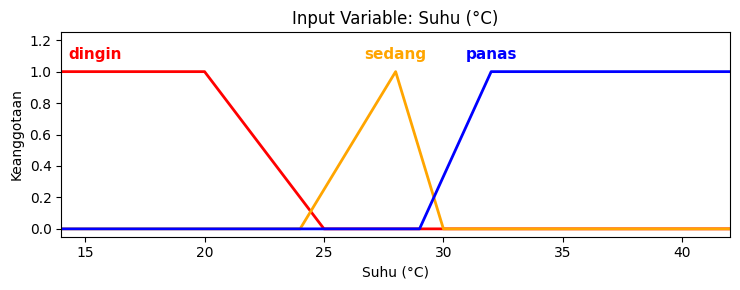

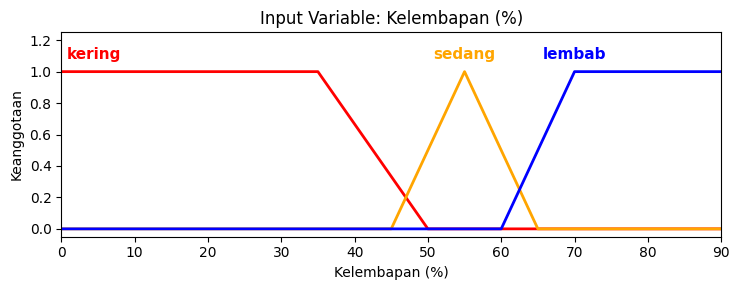

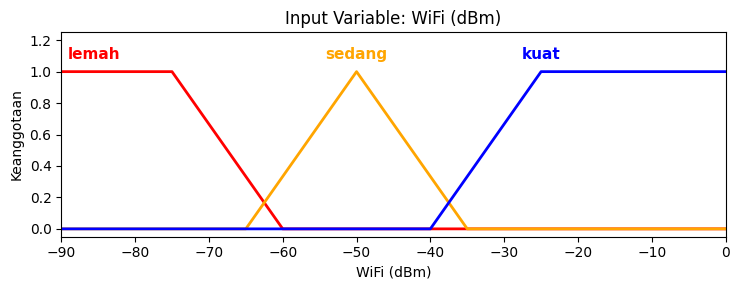

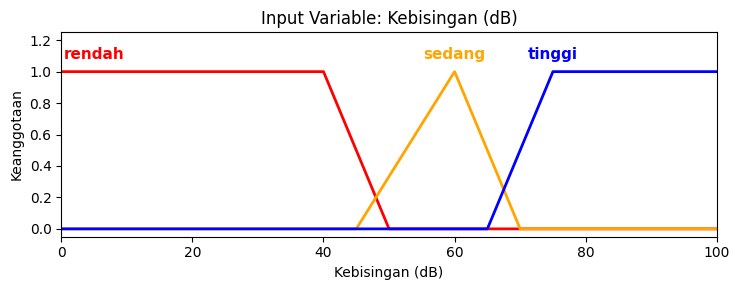

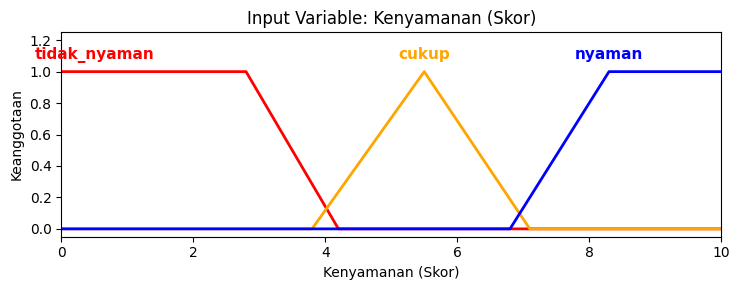

In [24]:
plot_mf_clean(suhu, "Suhu (°C)")
plot_mf_clean(kelembapan, "Kelembapan (%)")
plot_mf_clean(wifi, "WiFi (dBm)")
plot_mf_clean(kebisingan, "Kebisingan (dB)")
plot_mf_clean(kenyamanan, "Kenyamanan (Skor)")

grafik kuartal

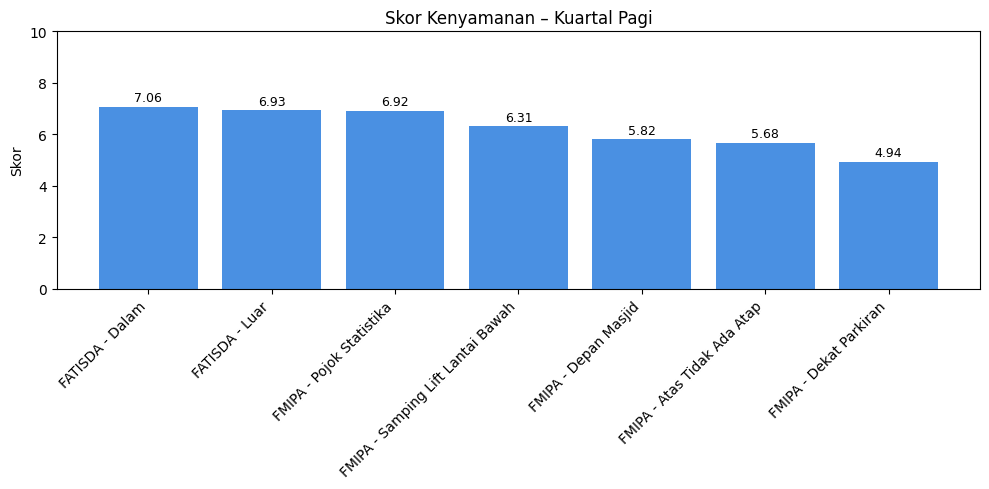

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
bars = plt.bar(ranking_pagi["TEMPAT"], ranking_pagi["skor_kenyamanan"], color="#4A90E2")

# Tambahkan angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.1, 
        f"{yval:.2f}", 
        ha='center', 
        va='bottom',
        fontsize=9
    )

plt.xticks(rotation=45, ha='right')
plt.title("Skor Kenyamanan – Kuartal Pagi")
plt.ylabel("Skor")
plt.ylim(0, 10)
plt.tight_layout()
plt.show()


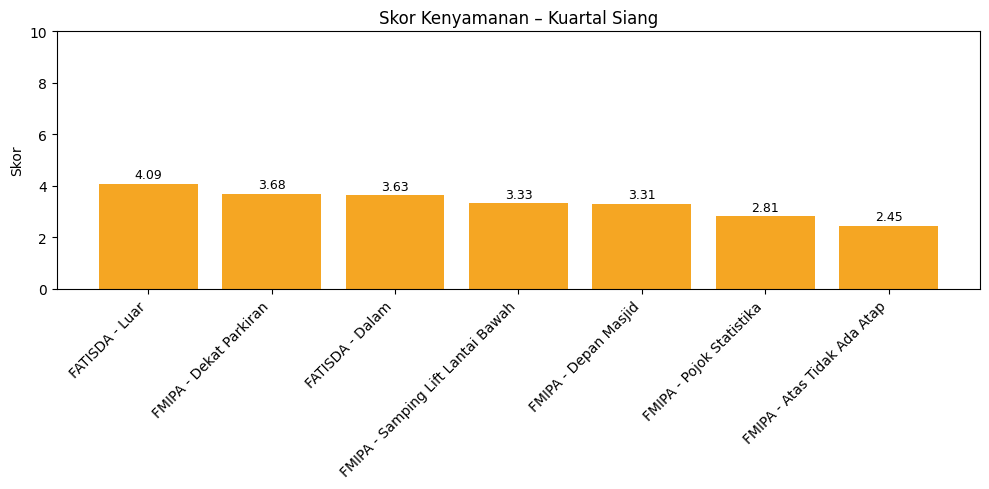

In [31]:
plt.figure(figsize=(10,5))
bars = plt.bar(ranking_siang["TEMPAT"], ranking_siang["skor_kenyamanan"], color="#F5A623")

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.1, 
        f"{yval:.2f}", 
        ha='center', 
        va='bottom',
        fontsize=9
    )

plt.xticks(rotation=45, ha='right')
plt.title("Skor Kenyamanan – Kuartal Siang")
plt.ylabel("Skor")
plt.ylim(0, 10)
plt.tight_layout()
plt.show()


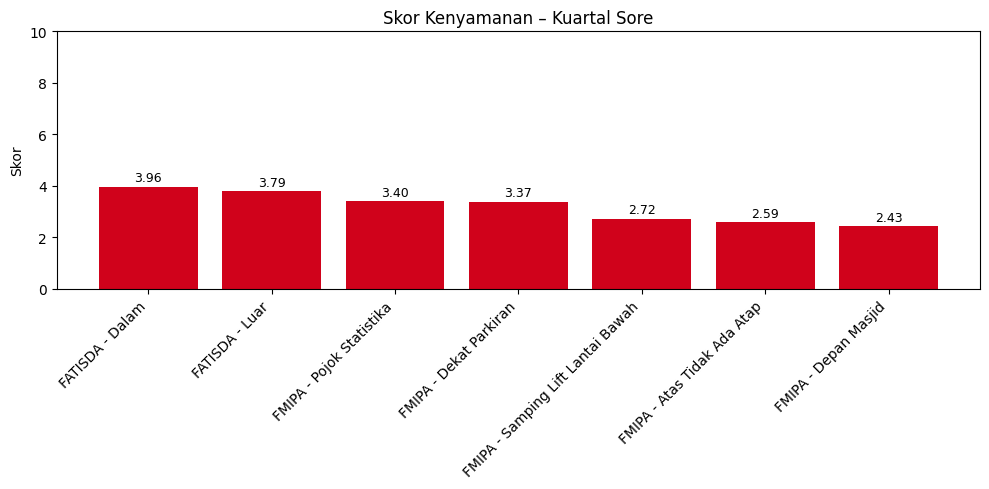

In [32]:
plt.figure(figsize=(10,5))
bars = plt.bar(ranking_sore["TEMPAT"], ranking_sore["skor_kenyamanan"], color="#D0021B")

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.1, 
        f"{yval:.2f}", 
        ha='center', 
        va='bottom',
        fontsize=9
    )

plt.xticks(rotation=45, ha='right')
plt.title("Skor Kenyamanan – Kuartal Sore")
plt.ylabel("Skor")
plt.ylim(0, 10)
plt.tight_layout()
plt.show()


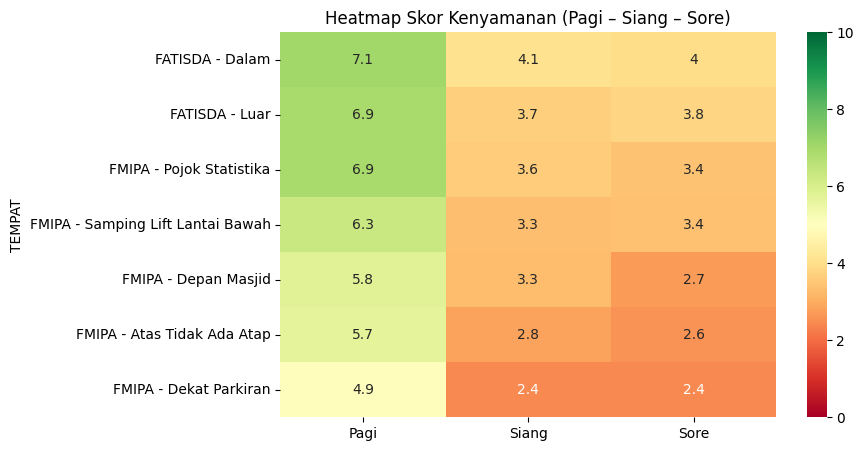

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gabungkan semua ranking ke satu tabel
heatmap_df = pd.DataFrame({
    "TEMPAT": ranking_pagi["TEMPAT"],
    "Pagi": ranking_pagi["skor_kenyamanan"].values,
    "Siang": ranking_siang["skor_kenyamanan"].values,
    "Sore": ranking_sore["skor_kenyamanan"].values
})

heatmap_df = heatmap_df.set_index("TEMPAT")

plt.figure(figsize=(8,5))
sns.heatmap(heatmap_df, annot=True, cmap="RdYlGn", vmin=0, vmax=10)
plt.title("Heatmap Skor Kenyamanan (Pagi – Siang – Sore)")
plt.show()


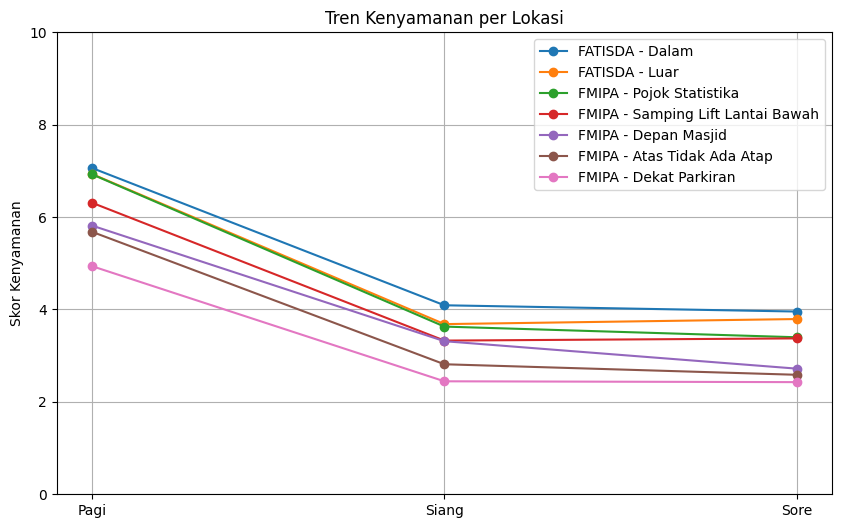

In [29]:
plt.figure(figsize=(10,6))

for tempat in heatmap_df.index:
    plt.plot(["Pagi", "Siang", "Sore"],
             heatmap_df.loc[tempat],
             marker="o",
             label=tempat)

plt.ylim(0,10)
plt.ylabel("Skor Kenyamanan")
plt.title("Tren Kenyamanan per Lokasi")
plt.legend()
plt.grid(True)
plt.show()
